## Configure

In [3]:
import pandas as pd
import numpy as np
import requests
import json
import time
from tqdm import tqdm
from pprint import pprint

from pororo import Pororo
import sqlite3

import re

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [4]:
mpl.rc("font", family='AppleGothic')
mpl.rc("axes", unicode_minus=False)

from IPython.display import set_matplotlib_formats

set_matplotlib_formats("retina")

FONT_PATH = '/System/Library/Fonts/Supplemental/AppleGothic.ttf'

## Loads Review Datasets

In [ ]:
reviews = pd.read_csv("data/review_since_20190101.csv", low_memory=False)

print(reviews.shape)
reviews.head(2)

## Loads Product Datasets

In [ ]:
products = pd.read_csv("data/products.csv", low_memory=False)

print(products.shape)
products.head(2)

## Preprocessing

### Drop Duplication

In [ ]:
reviews_backup1 = reviews.copy()

reviews = reviews.drop_duplicates(['user_name', 'message', 'product_id'], keep='last')

print(reviews.shape)
reviews.head()

### 직원 리뷰 지우기

In [ ]:
c1 = reviews['message(cleaned)'].str.contains("CS|MD")
c2 = reviews['user_name'].str.contains("사내판매|CS|MD|odemd|오드")

reviews_final = reviews[~(c1|c2)].copy()

print(reviews_final.shape)
reviews_final.head()

### Cleaning Message

- 공백 제거
- ?특수 문자 제거
    - !, ? 만 남기기

In [8]:
def preprocess_text(text):
    cleaned_text = text.replace("\n"," ")
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text) 
    
    return cleaned_text.strip()

In [ ]:
reviews['message(cleaned)'] = reviews['message'].apply(preprocess_text)

cols = ['message', 'message(cleaned)']
reviews[cols].head()

### Add Length of Message

In [ ]:
reviews['message_length'] = reviews['message(cleaned)'].str.len()

cols = ['message(cleaned)', "message_length"]
reviews[cols].head()

### Label Sentiment

토큰이 512개가 넘어가면 에러가난다. 따라서 토큰개수가 기준보다 많으면 가운데 100글자를 제거하고 다시 예측한다.
- 글의 서두와 말미에 감정을 보여주는 단어들이 주로 존재한다고 가정. 중심부는 설명문에 가까울 것이다!

In [ ]:
reviews.loc[reviews['score'] > 3, 'sentiment'] = 'Positive'
reviews.loc[reviews['score'] < 3, 'sentiment'] = 'Negative'
neutral_reviews = reviews.loc[reviews['score'] == 3]
# positive_reviews = reviews[reviews['score'] > 3]
# negative_reviews = reviews[reviews['score'] < 3]

print(neutral_reviews.shape)
neutral_reviews.head()

In [ ]:
sa = Pororo(task="sentiment", model="brainbert.base.ko.nsmc", lang="ko")

In [68]:
def predict_sentiment(message):
#     sa = Pororo(task="sentiment", model="brainbert.base.ko.nsmc", lang="ko")
    try:
        sentiment = sa(message)
        
    except :
        message_length = len(message)
        sentiment = predict_sentiment(message[: int(message_length / 2) - 50] + message[int(message_length / 2) + 50 :])
        
    return sentiment

In [69]:
predict_sentiment(reviews.loc[97474, 'message'])

'Negative'

In [ ]:
reviews.loc[reviews['score'] == 3, "sentiment"] = reviews.loc[reviews['score'] == 3, "message(cleaned)"].apply(predict_sentiment)
reviews.loc[reviews['score'].isnull(), 'sentiment'] = reviews.loc[reviews['score'].isnull(), 'message(cleaned)'].apply(predict_sentiment)

cols = ['message(cleaned)', 'sentiment']
reviews[cols].head()

In [75]:
# reviews.to_csv("data/backup.csv", index=False)

### Predict Score

- 지금은 공백만 제거하고(글자수 줄이기 위해) 넣어줬다. 뽀로로가 알아서 해줄거기 때문!

마찬가지로 토큰수가 512 이상이면 에러가 난다.

- 토큰수가 512 이하가 될 때까지 글의 중간을 삭제한다. 현재는 100자씩 삭제하였다. 글의 중간보다 앞뒤에 작성자의 감정이 더 담겨있을거라고 가정하였다. 글의 중간은 보통 상세한 설명 등의 분석글일 수 있다.

In [76]:
review_scorer = Pororo(task="review", lang="ko")

review_scorer

[TASK]: REVIEW
[LANG]: KO
[MODEL]: brainbert.base.ko.review_rating

In [13]:
print(review_scorer("진짜 너무 완전 짱 좋아요 추천 역대급"))
print(review_scorer("좋아요"), review_scorer("좋아요!"))
print(review_scorer("싫어요"), review_scorer("싫어요!"))
print(review_scorer("."), review_scorer("dd"), review_scorer("ㅇㄹㅁㄹㄴㅇ"))

4.96
4.6 4.83
1.35 1.28
3.34 3.91 3.01


In [79]:
def predict_score(message):
    try:
        score = review_scorer(message)
        
    except :
        message_length = len(message)
        score = review_scorer(message[: int(message_length / 2) - 50] + message[int(message_length / 2) + 50 :])
        
    return score

In [ ]:
reviews['score(predicted)'] = reviews['message(cleaned)'].apply(predict_score)

reviews.to_csv("data/reviews_predicted.csv", index=False)

cols = ['message(cleaned)', 'score(predicted)']
reviews.head()

In [82]:
reviews['score(difference)'] = abs(reviews['score'] - reviews['score(predicted)'])

cols = ['score', 'score(predicted)', 'score(difference)']
reviews[cols].describe()

,score,score(predicted),score(difference)
count,110794.000000,110794.000000,110794.000000
mean,4.852041,4.320705,0.594163
std,0.541954,0.672884,0.560135
min,1.000000,1.020000,0.000000
25%,5.000000,4.180000,0.250000
50%,5.000000,4.510000,0.450000
75%,5.000000,4.730000,0.740000
max,5.000000,5.060000,3.930000


<AxesSubplot:xlabel='score', ylabel='score(difference)'>

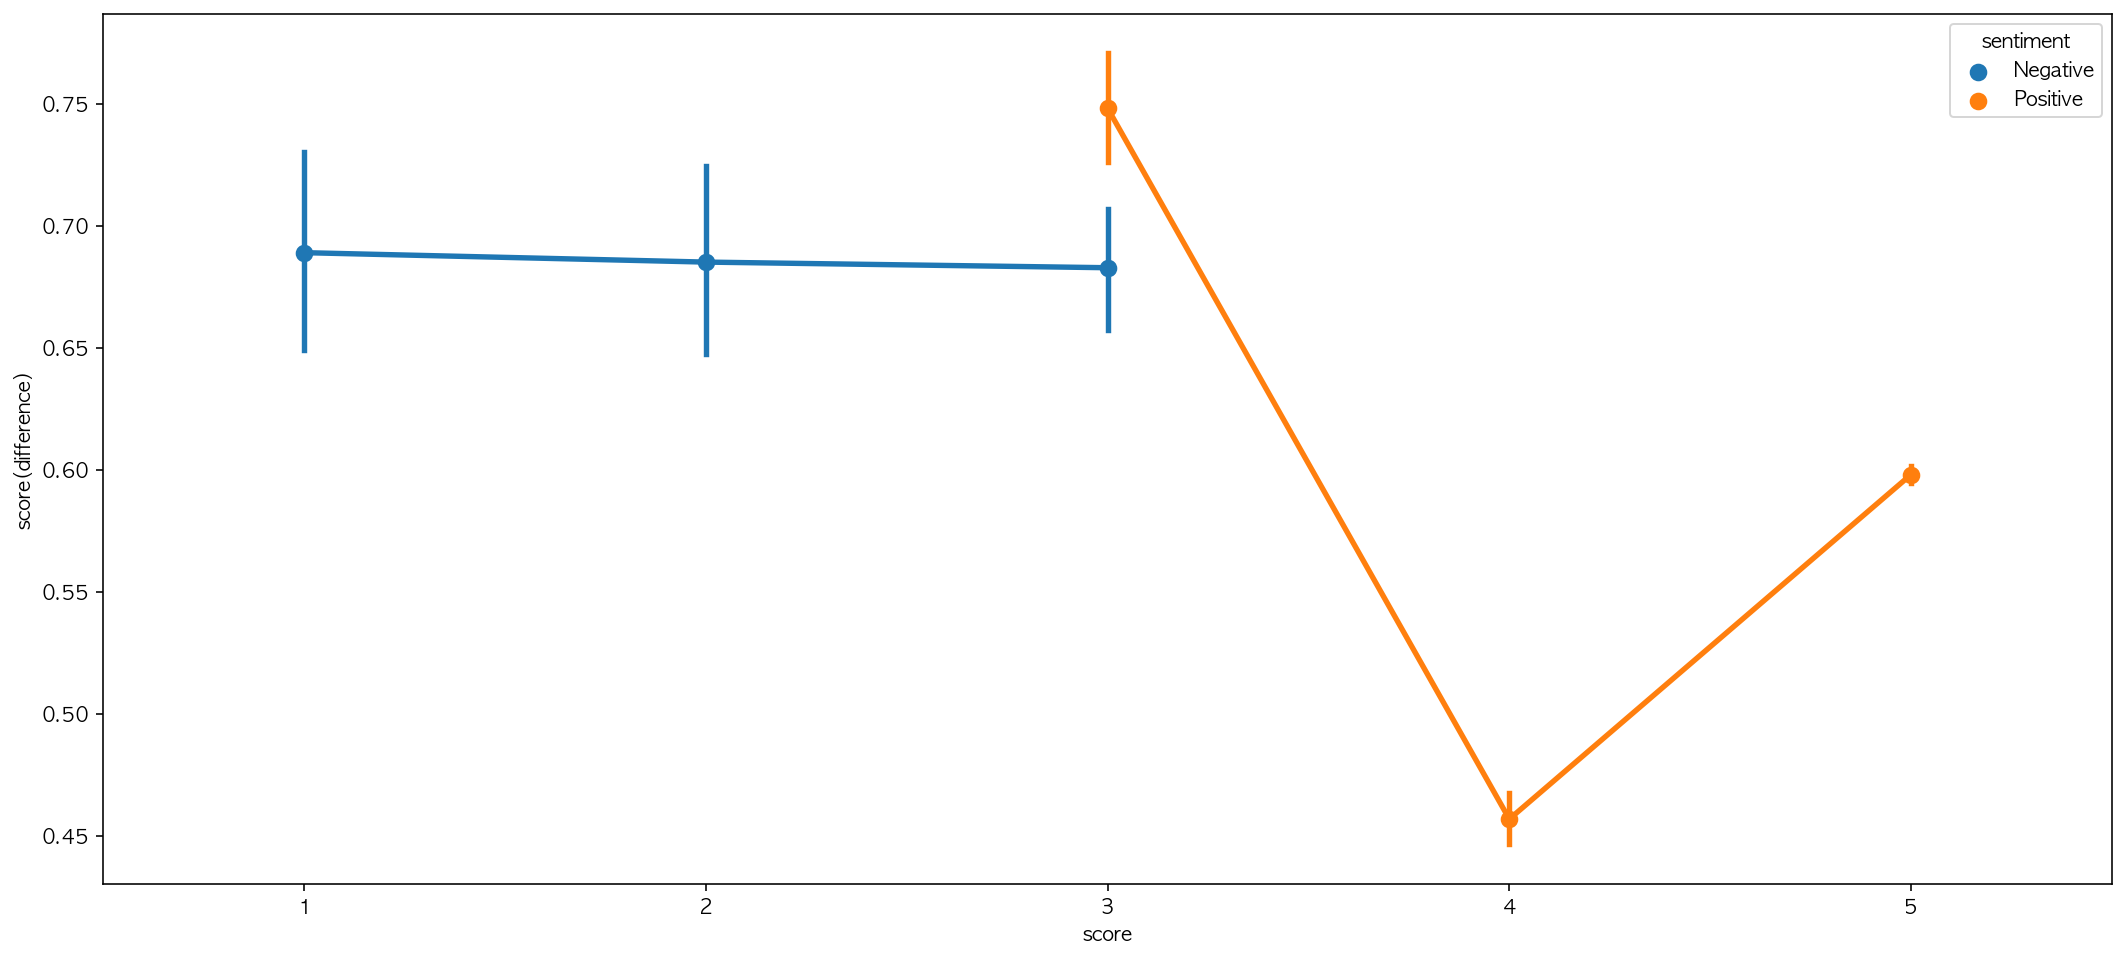

In [83]:
plt.figure(figsize=(18, 8))

sns.pointplot(data=reviews, x='score', y='score(difference)', hue='sentiment')

In [ ]:
plt.figure(figsize=(13, 5))

sns.distplot(reviews.loc[reviews['sentiment'] == 'Negative' , 'score(difference)'], hist=False)
sns.distplot(reviews.loc[reviews['sentiment'] == 'Positive' , 'score(difference)'], hist=False)

In [ ]:
plt.figure(figsize=(13, 8))

sns.boxplot(data=reviews, x='sentiment', y='score(difference)')

In [98]:
reviews['message_length(bin_100)'] = reviews['message_length'] // 100 * 100
reviews['message_length(bin_10)'] = reviews['message_length'] // 10 * 10

In [ ]:
# 부정 / 긍정별로
plt.figure(figsize=(18, 8))

sns.lineplot(data=reviews, x='message_length(bin_10)', y='score(difference)', hue='sentiment')

In [ ]:
# 부정 / 긍정별로
plt.figure(figsize=(18, 8))

sns.lineplot(data=reviews, x='message_length(bin_100)', y='score(difference)', hue='sentiment')

#### 긍정리뷰에 차이가 4가나는 튀는 값은 1점짜리로 도배?한 리뷰가 있는데 한 개의 리뷰가 5점(아무거나 넣은듯, 97478 인덱스)이라서 그렇다. 무시하면 된다.

In [ ]:
cols = ['message_length', 'score(predicted)', 'score(difference)']

# reviews[cols].corr()
reviews.loc[reviews['sentiment'] == 'Positive', cols].drop(97478).corr()

In [ ]:
reviews.loc[reviews['sentiment'] == 'Negative', cols].corr()

#### 메세지의 길이가 길어질수록 예측정확도가 떨어질 수 있다.
- 하지만 이는 뒤에서 나오듯이 고객이 별 생각없이 5점을 줬을 가능성이 있다. 
    - "좋은데 이건 저건 요건 조금 아쉽네요~" 이런식으로 문장은 길지만 5점을 준 경우들이 꽤 있다.
    
결론적으로 대표 스코어(스코어의 평균)을 계산할 때 평균낼 스코어들을 뽑는 기준으로 메세지의 최소 길이를 정해줄 수 있다. 지금은 x

In [ ]:
reviews.loc[reviews['message_length'] < 10, cols]

In [137]:
cols = ['message', 'score', 'score(predicted)']

# 3885개
reviews.loc[reviews['score(difference)'] > 1.5, cols]

,message,score,score(predicted)
2,러블리 리본패턴 배색 플레어 원피스 \n키158cm인 저한테는 무릎쯤 오고\n디자인...,5,2.71
38,배송이 좀 느렸고 기본적인 흰색 면셔츠네요.\n단품으로도 입고 레이어드해서도 입고 ...,5,3.46
41,만지는순간 보들보들 입을려고하는순간 뭔가 타이트하다라는느낌~~스판은 좋으나 ...,5,2.57
77,"겨울임을 감안하고 샀어야 하는데, 예상했던 것과는 조금 다르지만 디자인 자체는 나쁘...",5,3.08
113,따뜻하고 풍성한데~ 너무 두꺼워서 좀 답답하고 약간 오버하는 기분도들어요 ㅎㅎ 근데...,5,3.18
...,...,...,...
110936,좀더 신경써주시길,5,2.40
110937,주머니부분\n부자연스럽구\n밑부분 뒷트입이필요할듯\n종종걸음,5,3.07
110947,옷은이뻐요 색상도 이쁘구요 근데 가슴이 큰편이라\n주름이 많이가니 핏이 죽더라고요\...,5,1.69
110956,디자인이 여성스럽고 화사할 것 같아 구매했어요\n샹각했던 것과 같은 느낌인데 재질이...,5,3.16


<AxesSubplot:xlabel='score(predicted)', ylabel='Density'>

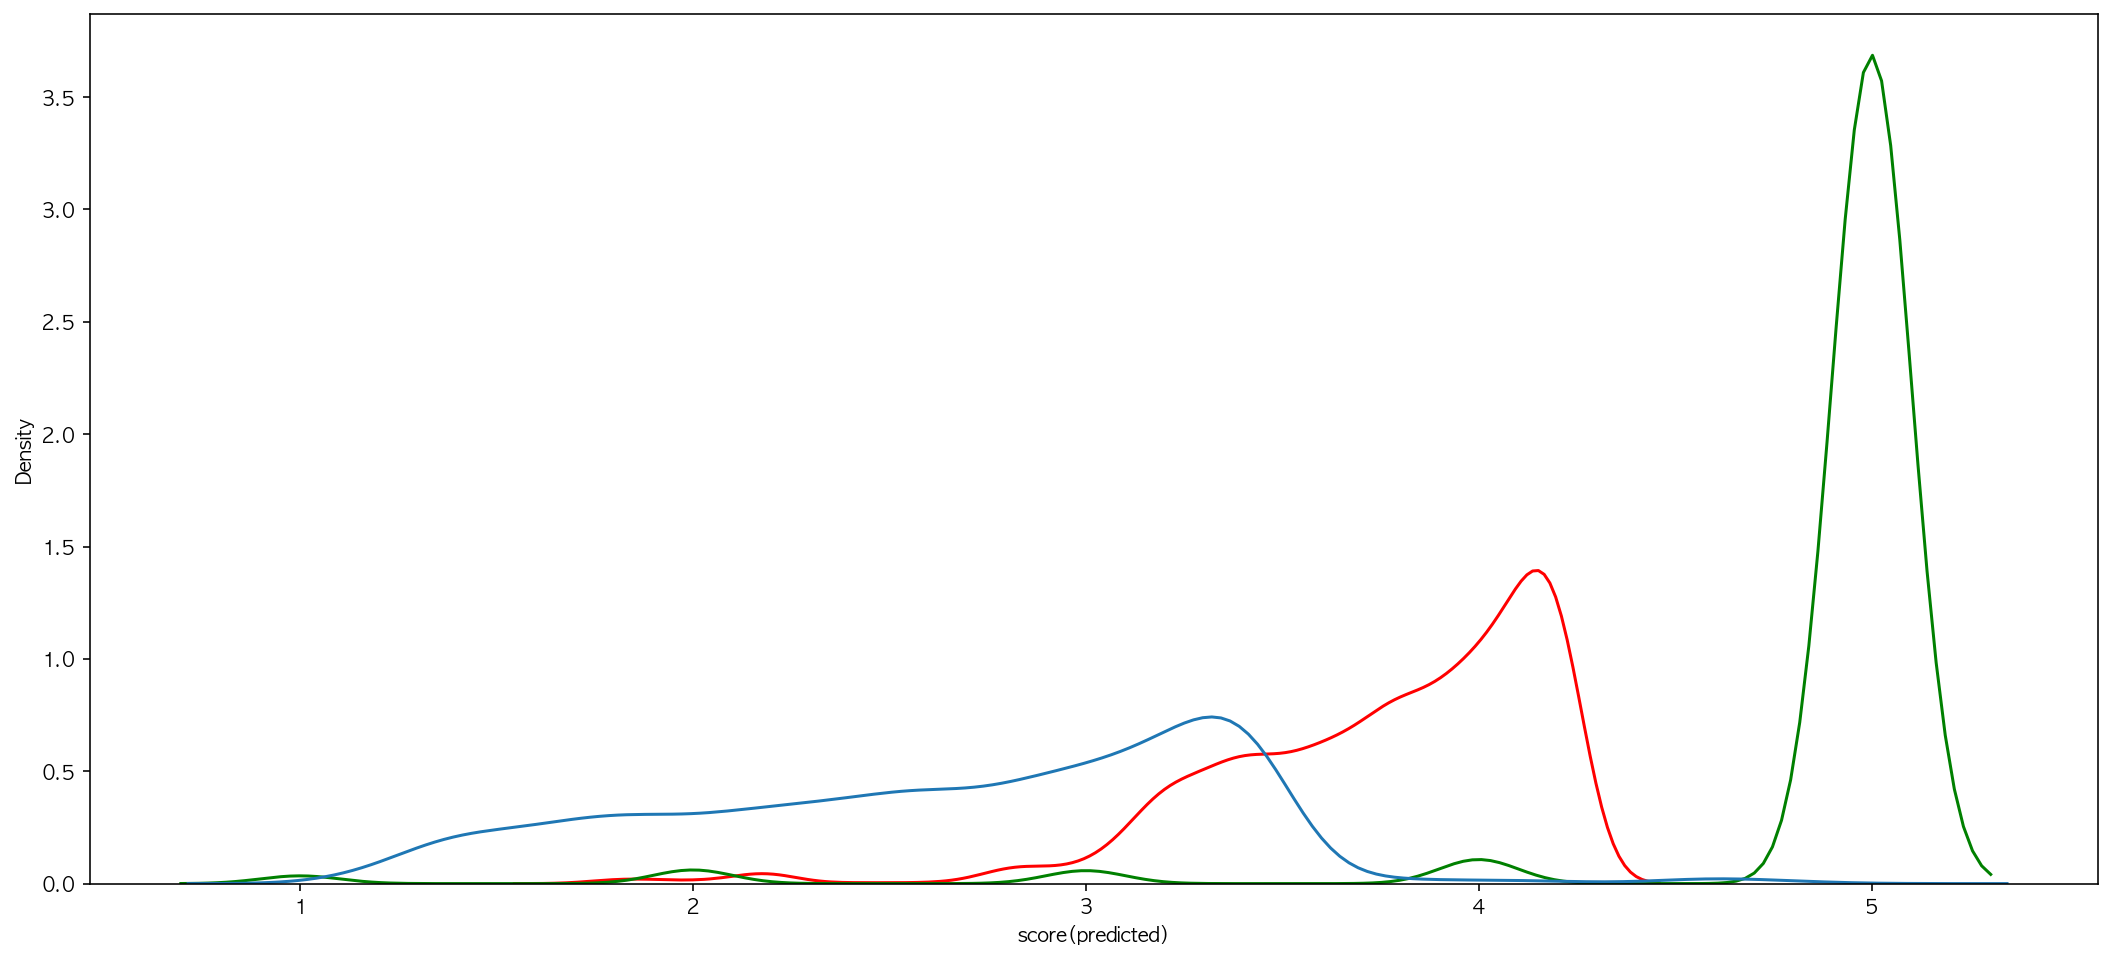

In [134]:
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(18, 8))

tmp = reviews.loc[reviews['score(difference)'] > 1.5]

sns.distplot((tmp['score(predicted)'] + tmp['score']) / 2, hist=False, color='red')
sns.distplot(tmp['score'], hist=False, color='green')
sns.distplot(tmp['score(predicted)'], hist=False)

예측 스코어랑 차이가 많이 나는 것들을 보면 고객인 준 점수가 참고할만한(신뢰할만한) 점수인지 애매하다.
- 옷은 예쁜데 몇가지가 맘에 들지 않는다 or 주문취소인 경우가 보인다.

차이가 큰 것들의 케이스는 아래와 같다.

case 1
```
후기 : 안따듯해요	
고객점수 : 1
예측점수 : 3.35

이 케이스는 뽀로로가 예측한 점수가 아닌 고객점수를 사용한다.
```
      
      
case 2
```
후기 : 좀더신경써주길	
고객점수 : 5
예측점수 : 2.40

이 케이스는 고객이 만족은 하는데 조금 아쉬워하는 케이스. 결론적으로 만족! 고객의 만족을 반영하기 위해 고객점수랑 예측점수를 평균낸다.
```


1. [x] 고객점수가 더 높으면서 차이가 큰 경우만 예측한 점수와 고객의 점수의 평균
2. 뽀로로가 예측한 점수로 대체



### Get Mean of Score 

고객점수가 더 높으면서 차이가 큰 경우만 예측한 점수와 고객의 점수의 평균내어 사용한다.

차이는 임의로 1.5로 지정한다.

In [ ]:
reviews['score(final)'] = reviews['score(predicted)'].copy()

c1 = reviews['score(difference)'] >= 1.5
c2 = reviews['score(predicted)'] < reviews['score']

reviews.loc[c1&c2, 'score(final)'] = (reviews.loc[c1&c2, 'score'] + reviews.loc[c1&c2, 'score(predicted)']) / 2

cols = ['score', 'score(predicted)', 'score(final)', 'message(cleaned)']
reviews.loc[c1&c2, cols].head()

### 대표 스코어 선정

In [ ]:
score_per_product = reviews.groupby("product_code")['score(final)'].mean().reset_index()

products = products.merge(score_per_product, left_on='code', right_on='product_code', how='left')

print(products.shape)
products.head()

### 대표 리뷰 뽑기

현재는 score_final이 가장 높은 리뷰를 뽑는다.

같은 값이 있을 수 있는데 현재는 쉽게 가자! 첫 번째 값을 뽑는다.

In [ ]:
# product마다 최대가 되는 index를 뽑는다. 인덱스를 id로 지정하고 시작하면 rename을 번거롭게 하지 않아도 될듯하네 ㅇㅅㅇ
df = reviews.groupby("product_id")['score_final'].idxmax()\
        .reset_index()\
        .rename(columns={"score_final" : "index"})\
        .sort_values("product_id")
#         .rename(columns={"score_final" : "representative_reviews"})
# reviews.loc[idx, 'score_final'].reset_index().rename(columns={"score_final" : "max_score_of_product"})

# 뽑은 index의 review_id를 뽑는다.
# 혹시 모르니 정렬을 잘해주자.
df['representative_review_id'] = reviews.loc[df['index'].values].sort_values('product_id')['id'].values

# 사용할 컬럼만 뽑고
df = df[['product_id', 'representative_review_id']]

# merge 해주자!
products_final = products_final.merge(df, left_on='id', right_on="product_id", how='left')

print(products_final.shape)
products_final.head()

In [ ]:
cols = ['id', 'name', 'code', 'representative_score', 'representative_review_id', 'display', 'created_at',
       'updated_at', 'shop_builder_created_at', 'shop_builder_updated_at',
       'reviews_count', 'org_price', 'final_price', 'product_status', 'image',
       'message_positive', 'top1_sentence_of_positive_reviews',
       'top2_sentence_of_positive_reviews',
       'top3_sentence_of_positive_reviews',
       'top4_sentence_of_positive_reviews',
       'top5_sentence_of_positive_reviews',
       'related_10_reviews_with_top1_sentence_of_positive_reviews',
       'related_10_reviews_with_top2_sentence_of_positive_reviews',
       'related_10_reviews_with_top3_sentence_of_positive_reviews',
       'related_10_reviews_with_top4_sentence_of_positive_reviews',
       'related_10_reviews_with_top5_sentence_of_positive_reviews',
       'message_negative', 'top1_sentence_of_negative_reviews',
       'top2_sentence_of_negative_reviews',
       'top3_sentence_of_negative_reviews',
       'top4_sentence_of_negative_reviews',
       'top5_sentence_of_negative_reviews',
       'related_10_reviews_with_top1_sentence_of_negative_reviews',
       'related_10_reviews_with_top2_sentence_of_negative_reviews',
       'related_10_reviews_with_top3_sentence_of_negative_reviews',
       'related_10_reviews_with_top4_sentence_of_negative_reviews',
       'related_10_reviews_with_top5_sentence_of_negative_reviews',]

products_final = products_final[cols]

products_final.head()

In [132]:
products_final = products_final.merge(reviews_final[['id', 'message']].rename(columns={'id' : "review_id"}), 
                                     left_on='representative_review_id', right_on='review_id')\
                                .drop(columns='review_id')\
                                .rename(columns={'message' : "representative_review_message"})


products_final.head()

,id,name,code,representative_score,representative_review_id,display,created_at,updated_at,shop_builder_created_at,shop_builder_updated_at,...,top2_sentence_of_negative_reviews,top3_sentence_of_negative_reviews,top4_sentence_of_negative_reviews,top5_sentence_of_negative_reviews,related_10_reviews_with_top1_sentence_of_negative_reviews,related_10_reviews_with_top2_sentence_of_negative_reviews,related_10_reviews_with_top3_sentence_of_negative_reviews,related_10_reviews_with_top4_sentence_of_negative_reviews,related_10_reviews_with_top5_sentence_of_negative_reviews,representative_review_message
0,224376,글램 실키 슬립,37296,4.155595,4676708.0,True,2014-01-21T00:16:46.000+09:00,2021-02-15T03:46:27.000+09:00,2010-09-28T18:02:40.000+09:00,2019-11-29T00:15:01.000+09:00,...,패망임.. ㅋ후기 보니 헐렁하대서. .ㅋㅋ,생각보다 너무 짧아요...,못 입을 정도는 아니지만 타이트하다는.. ᅮᅮ 여러 개 시 켰는데..,다들 넉넉하다는 후기 보고 s 시켰는데..,"[4716704, 4716697, 4597523, 4725377, 4676748, ...","[4711430, 4716704, 4711426, 4716697, 4676748, ...","[4716704, 4597523, 4716697, 4676748, 4723403, ...","[4711426, 4676748, 4703860, 4716704, 4711430, ...","[4716704, 4711426, 4650096, 4716697, 4676748, ...",넘넘 아쁘고 고급집니다55잘 맞습니다 골드의 윤택이 빛이 납니다 감사합니다 겔이...
1,224400,실리콘 누브라,48837,4.450000,4686224.0,True,2014-01-21T00:16:52.000+09:00,2020-12-07T18:29:44.000+09:00,2011-04-28T18:25:42.000+09:00,2019-11-29T00:15:01.000+09:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,볼륨도 살아보이고 접착부분이 너무 좋네요💞💞\n👉연결부분도 넘좋아 많족하고 착용했습...
2,224449,40NY 슬림 착압 스타킹,791639,4.472797,4613084.0,True,2014-01-21T00:17:22.000+09:00,2021-02-16T04:58:22.000+09:00,2013-09-25T17:51:24.000+09:00,2020-05-25T14:49:09.000+09:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"너무너무 좋아요.진짜진짜 찿고찿았던 스타킹,재구매들어갑니다.겨울용 두껍고 여름용은 ..."
3,224454,동글 블랙 안경테,60281,4.611071,4599943.0,True,2014-01-21T00:17:25.000+09:00,2021-01-21T11:05:04.000+09:00,2012-05-10T11:46:39.000+09:00,2019-11-29T00:16:28.000+09:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,디자인 고급스럽고 예뻐요. 안경점에서 구입한 것 보다 더 깔끔하면서도 단단해서 컴퓨...
4,224519,소프트 누드 팬티,37303,4.520000,4687643.0,True,2014-01-21T00:18:04.000+09:00,2021-02-16T19:40:20.000+09:00,2010-09-28T18:16:12.000+09:00,2019-11-29T00:15:01.000+09:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"구입하고 오늘 입어보니, 착용감이 너무 좋아\n조만간 몇장 더 구입할려구요.\n가볍..."


### 상품별로 후기 모아놓기

In [165]:
reviews['message(for_groupby)'] = reviews['message(cleaned)'] + "\n"

positive_reviews_per_product = reviews[reviews['sentiment'] == 'Positive']\
                                        .groupby("product_code")['message(for_groupby)'].sum().reset_index()\
                                        .rename(columns={'message(for_groupby)' : "message(positive)"})
negative_reviews_per_product = reviews[reviews['sentiment'] == 'Negative']\
                                        .groupby("product_code")['message(for_groupby)'].sum().reset_index()\
                                        .rename(columns={'message(for_groupby)' : "message(negative)"})

products = products.merge(positive_reviews_per_product, left_on='code', right_on='product_code', how='left')\
                    .merge(negative_reviews_per_product, left_on='code', right_on='product_code', how='left')\

print(products.shape)
products.head()

(37112, 17)


,id,name,code,display,created_at,updated_at,shop_builder_created_at,shop_builder_updated_at,reviews_count,org_price,final_price,product_status,image,product_code_x,message(positive),product_code_y,message(negative)
0,224370,와이드 퍼 무스탕,796006,True,2014-01-21T00:16:42.000+09:00,2020-12-07T18:29:42.000+09:00,2013-12-04T14:40:20.000+09:00,2019-06-03T20:49:00.000+09:00,3,89700,89700,selling,{'middle_url': 'https://assets1.cre.ma/p/ode-c...,NaN,NaN,NaN,NaN
1,224371,잔꽃 코듀로이 블라우스,796004,True,2014-01-21T00:16:43.000+09:00,2020-12-07T18:29:42.000+09:00,2013-12-04T14:40:20.000+09:00,2019-06-12T14:25:00.000+09:00,1,51300,36000,selling,{'middle_url': 'https://assets1.cre.ma/p/ode-c...,NaN,NaN,NaN,NaN
2,224372,레디아 체크 스커트,795594,True,2014-01-21T00:16:43.000+09:00,2020-12-07T18:29:42.000+09:00,2013-11-26T16:44:02.000+09:00,2019-06-12T14:50:00.000+09:00,2,34600,17300,selling,{'middle_url': 'https://assets1.cre.ma/p/ode-c...,NaN,NaN,NaN,NaN
3,224373,샤론 스트링 조끼,793896,True,2014-01-21T00:16:45.000+09:00,2020-12-07T18:29:42.000+09:00,2013-11-01T17:12:51.000+09:00,2019-06-03T20:57:00.000+09:00,2,78600,78600,selling,{'middle_url': 'https://assets1.cre.ma/p/ode-c...,NaN,NaN,NaN,NaN
4,224374,이브 플레어 블라우스,794045,True,2014-01-21T00:16:45.000+09:00,2020-12-07T18:29:42.000+09:00,2013-11-04T17:16:40.000+09:00,2019-06-12T14:24:00.000+09:00,3,34800,34800,selling,{'middle_url': 'https://assets1.cre.ma/p/ode-c...,NaN,NaN,NaN,NaN


### 스코어링 근거(키워드 or 키센텐스) 뽑기

현재는 키워드 결과가 좋지 않아 키센텐스를 뽑는 것으로 진행. 사실 키센텐스는 키워드를 기준으로 뽑히는거라...보완해야한다.

#### 근거 후보

    1. 키워드
        - 핵심이 되는 단어뽑기
        - 클릭하면 키워드가 포함된 리뷰를 보여주기

    2. 키센텐스
        - 핵심이 되는 문장뽑기
        - 클릭하면 키센텐스와 유사도가 높은 문장을 보여주기
            
####  공통 문제점

- 맞춤법 결과 이상, 문장 분리 문제, min_count 지정, 불용어 직접 지정
    - 글자수가 너무 길면 제대로 처리가 안된다. 현재는 글자수가 길어 문제가 발생하는 메세지들은 맞춤법 처리를 진행하지 않았다.
- 키센텐스/키워드가 안뽑히는 케이스
    - 대표할만한 문장이 없으면?            
            
#### 보완책

    1. 정제 빡세게 하고(기본형 만들기까지. 큰 -> 크다). 토큰화까지 진행
    2. 키워드를 직접 지정하여 카운트하기. 예시) 튿다, 뜯다, 크다, 작다, 좋다. 
    3. 키센텐스의 경우 마지막 결과를 뽀로로 한 번 더 요약하여 글자수 줄이기.(의미없는 단어 줄이기)

In [4]:
from krwordrank.sentence import summarize_with_sentences
from hanspell import spell_checker
from kss import split_sentences


stopwords = {'.', "은", '는', '이', '를', '을', '가', '다', '죠', '이다', '에', '에서', '진짜', '너무', '많이','ㅎㅎ', 'ㅋㅋ', 'ㅎ', 'ㅋ',
            '제가', '거', '수', '것', '하다'}

i = 1

# 대표할만한 문장이 없으면? 아무 문장 또는 가장 길이가 긴 리뷰...?

# 몇 가지 패러매터를 추가할 수 있습니다. 
# 길이가 지나치게 길거나 짧은 문장을 제거하기 위해 penalty 함수를 정의합니다. 
# 아래는 길이가 25 글자부터 80 글자인 문장을 선호한다는 의미입니다. 
# stopwords 는 키워드에서 제거합니다. 이들은 키워드벡터를 만들 때에도 이용되지 않습니다. 
# 또한 키워드 벡터와 유사한 문장을 우선적으로 선택하다보면 이전에 선택된 문장과 중복되는 문장들이 선택되기도 합니다.
# 이는 diversity 를 이용하여 조절할 수 있습니다. diversity 는 코싸인 유사도 기준 핵심문장 간의 최소 거리 입니다. 이 값이 클수록 다양한 문장이 선택됩니다.
# 만약 마지막이라는 단어가 포함된 문장도 핵심 문장에서 제거하고 싶다면 아래처럼 penalty 함수를 변경할 수 있습니다.
# penalty=lambda x:0 if (25 <= len(x) <= 80 and not '마지막' in x) else 1,
def get_top5_sentences(message, penalty=None, stopwords=None,
                     min_count=2, diversity=0.3,
                     num_keywords=100, num_keysents=5, **kwargs):
    
    global i
    print(i)
    i += 1
    
    if message is np.nan:
        return message
    
    try:
        checked_message = spell_checker.check(message).as_dict()['checked']
        
        if checked_message == '':
            checked_message = message
        sentences = split_sentences(checked_message)

#         print(checked_message)

        keywords, sents = summarize_with_sentences(
            sentences,
            penalty=None,
            min_count=min_count,
            stopwords = stopwords,
            diversity=diversity,
            num_keywords=num_keywords,
            num_keysents=num_keysents ,
        )    

        return list(set(sents))

    except:
        return np.nan

In [210]:
sentence_similarity = Pororo(task="similarity", lang="ko")

def get_similar_reviews(row, reviews):
    new_negative_cols = [f"top{i}_sentence_of_negative_reviews" for i in range(1, num_keysents + 1)]
    new_positive_cols = [f"top{i}_sentence_of_positive_reviews" for i in range(1, num_keysents + 1)]
    
    result = {}
    print(row['id'])
    
    # 연산량 때문에 지금은 컬럼 한개만...
    for col in (new_positive_cols+ new_negative_cols)[:1]:
        message = row[col]
        new_col = "10_reviews_related_with_" + col
        
        if pd.isnull(message):
#             values = message
            continue

        else:
            try:
                product_id = row['id']
                related_reviews_index = reviews.loc[reviews['product_id'] == product_id, 'message(cleaned)']\
                                                .apply(sentence_similarity, args=(message, ))\
                                                .sort_values(ascending=False)\
                                                .head(10).index
                
                values = reviews.loc[related_reviews_index, 'id'].to_list()
            except:
                values = np.nan
                pass
        
        result[new_col] = values
        
    return result

In [ ]:
# 결과 이상한 것들 확인
c1 = products['message(negative)'].notnull()
c2 = tmp.isnull()

products.loc[c1&c2, 'message(negative)']

여기서부터는 디비를 위해서!

In [31]:
reviews = pd.read_csv("data/final/reviews.csv", low_memory=False)
products = pd.read_csv("data/final/products_final.csv", low_memory=False)

print(reviews.shape, products.shape)

(107961, 23) (37112, 48)


In [ ]:
products.columns

### 컬럼명 처리, 사용할 컬럼 뽑기

1. 특수기호는 _ 로
2. 숫자시작하는 것은 없애기
3. 순서지정

In [ ]:
cols_mapper = {
    'message(negative)' : 'message_negative',
    'message(positive)' : "message_positive",
    'score(final)' : "representive_score",
}

products_final = products.rename(columns=cols_mapper).copy()

products_final.columns = products_final.columns.str.replace("10_reviews_related", "related_10_reviews")

use_cols = ['id', 'name', 'code', 'representive_score', 'representive_review_id', 'display', 'created_at', 'updated_at',
       'shop_builder_created_at', 'shop_builder_updated_at', 'reviews_count',
       'org_price', 'final_price', 'product_status', 'image',
                   'message_positive',
       'top1_sentence_of_positive_reviews',
       'top2_sentence_of_positive_reviews',
       'top3_sentence_of_positive_reviews',
       'top4_sentence_of_positive_reviews',
       'top5_sentence_of_positive_reviews',
       'related_10_reviews_with_top1_sentence_of_positive_reviews',
       'related_10_reviews_with_top2_sentence_of_positive_reviews',
       'related_10_reviews_with_top3_sentence_of_positive_reviews',
       'related_10_reviews_with_top4_sentence_of_positive_reviews',
       'related_10_reviews_with_top5_sentence_of_positive_reviews',
        'message_negative',
       'top1_sentence_of_negative_reviews',
       'top2_sentence_of_negative_reviews',
       'top3_sentence_of_negative_reviews',
       'top4_sentence_of_negative_reviews',
       'top5_sentence_of_negative_reviews',
       'related_10_reviews_with_top1_sentence_of_negative_reviews',
       'related_10_reviews_with_top2_sentence_of_negative_reviews',
       'related_10_reviews_with_top3_sentence_of_negative_reviews',
       'related_10_reviews_with_top4_sentence_of_negative_reviews',
       'related_10_reviews_with_top5_sentence_of_negative_reviews',]

products_final = products_final[use_cols].copy()

print(products_final.shape)
products_final.head()

In [136]:
use_cols = ['id', 'code', 'user_id', 'user_code', 'user_name', 'message', 'message(cleaned)',
            'score', 'score(predicted)', 'score(final)', 'sentiment',
       'created_at', 'updated_at', 'product_id', 'product_code',
       'images_count', 'images', 'likes_count', 'plus_likes_count',
       'comments_count', 'source', 'options', 'product_options', ]

cols_mapper = {
    'message(cleaned)' : 'message_cleaned',
    'score(predicted)' : "score_predicted",
    'score(final)' : "score_final",    
}

reviews_final = reviews[use_cols].rename(columns=cols_mapper).copy()

print(reviews_final.shape)
reviews_final.head()

(107961, 23)


,id,code,user_id,user_code,user_name,message,message_cleaned,score,score_predicted,score_final,sentiment,created_at,updated_at,product_id,product_code,images_count,images,likes_count,plus_likes_count,comments_count,source,options,product_options
0,4592565,NaN,5562367,jmi703jmi,장명일,\n댓글이좋아서 구매했는데\n세탁후 통도많이넓어지고\n색상도 희끗해지고\n별로맘에안...,댓글이좋아서 구매했는데 세탁후 통도많이넓어지고 색상도 희끗해지고 별로맘에안들어요...,1,1.89,1.890,Negative,2019-01-01 00:32:52+09:00,2020-10-30 04:24:02+09:00,945527,837698,0,[],0,0,0,brand_mobile_my_orders,[],"{'색상': '카키', '사이즈': 'L(29~30)'}"
1,4592566,NaN,5559704,nh@bffc0ca8,허성미,고민고민하다 후기 보고 구매했는데 길이도 딱 맞고 핏도 너무 좋네요. 다들 이쁘다고...,고민고민하다 후기 보고 구매했는데 길이도 딱 맞고 핏도 너무 좋네요. 다들 이쁘다고...,5,4.79,4.790,Positive,2019-01-01 03:00:48+09:00,2020-10-15 06:09:01+09:00,952266,874347,0,[],0,0,0,brand_mobile_popup,"[{'id': 771817, 'review_id': 4592566, 'review_...","{'색상': '와인', '사이즈': 'S(25~26)'}"
2,4592567,NaN,5486570,suk1878,최계숙,러블리 리본패턴 배색 플레어 원피스 \n키158cm인 저한테는 무릎쯤 오고\n디자인...,러블리 리본패턴 배색 플레어 원피스 키158cm인 저한테는 무릎쯤 오고 디자인도 이...,5,2.71,3.855,Positive,2019-01-01 03:12:03+09:00,2020-11-27 05:16:50+09:00,957076,886773,0,[],1,1,1,brand_mobile_popup,"[{'id': 771822, 'review_id': 4592567, 'review_...","{'색상': '핑크(빠른배송)', '사이즈': 'S(55)'}"
3,4592568,NaN,5323820,mmh030,문명희,그레이 색상 구입했는데\n너무 이쁘고 편해서 블랙도 구매했어요,그레이 색상 구입했는데 너무 이쁘고 편해서 블랙도 구매했어요,5,4.68,4.680,Positive,2019-01-01 06:38:42+09:00,2020-11-10 21:04:09+09:00,957032,886662,0,[],0,0,0,brand_mobile_popup,"[{'id': 771825, 'review_id': 4592568, 'review_...","{'색상': '블랙', '사이즈': 'Free(55~66)'}"
4,4592569,NaN,5377569,0624shee,박성희,스커트가 톡톡해서 한겨울 입기도좋고 예쁩니다. 색상도 화면과 같구요 한겨울 잘입을수...,스커트가 톡톡해서 한겨울 입기도좋고 예쁩니다. 색상도 화면과 같구요 한겨울 잘입을수...,5,4.67,4.670,Positive,2019-01-01 08:49:14+09:00,2019-02-17 18:13:52+09:00,957261,887248,0,[],0,0,1,brand_mobile_my_orders,"[{'id': 771828, 'review_id': 4592569, 'review_...","{'색상': '딥그린', '사이즈': 'M(27~28)'}"


### JSON 변환

#### products

먼저 데이터 타입 확인

In [44]:
products_final['image'].iloc[0]

"{'middle_url': 'https://assets1.cre.ma/p/ode-co-kr/products/00/00/22/43/70/image/middle_47651f7741032bfd.jpg', 'middle_width': 512, 'middle_height': 512}"

In [45]:
products_final.columns

Index(['id', 'name', 'code', 'representive_score', 'display', 'created_at',
       'updated_at', 'shop_builder_created_at', 'shop_builder_updated_at',
       'reviews_count', 'org_price', 'final_price', 'product_status', 'image',
       'message_positive', 'top1_sentence_of_positive_reviews',
       'top2_sentence_of_positive_reviews',
       'top3_sentence_of_positive_reviews',
       'top4_sentence_of_positive_reviews',
       'top5_sentence_of_positive_reviews',
       'related_10_reviews_with_top1_sentence_of_positive_reviews',
       'related_10_reviews_with_top2_sentence_of_positive_reviews',
       'related_10_reviews_with_top3_sentence_of_positive_reviews',
       'related_10_reviews_with_top4_sentence_of_positive_reviews',
       'related_10_reviews_with_top5_sentence_of_positive_reviews',
       'message_negative', 'top1_sentence_of_negative_reviews',
       'top2_sentence_of_negative_reviews',
       'top3_sentence_of_negative_reviews',
       'top4_sentence_of_negative_revi

In [ ]:
products_final.loc[products_final['related_10_reviews_with_top1_sentence_of_negative_reviews'].notnull(), 'related_10_reviews_with_top1_sentence_of_negative_reviews'].iloc[0]

- related_10_reviews_with_negative : 이미 작은 따옴표로 잘 감싸져 있다. 오케이! 그대로 두면 된다!
- image : 큰 따옴표로 감싸져 있다. 작은 따옴표와 큰 따옴표의 위치를 바꾸자.

In [ ]:
# json 타입 변환
# 원래는 nan 확인해주는게 맞다..!
products_final.loc[products_final['image'].notnull(), 'image'] = \
                        products_final.loc[products_final['image'].notnull(), 'image'].str.replace("\'", '\"')


products_final.loc[products_final['image'].notnull(), 'image'].iloc[0]

In [ ]:
products_final.head()

#### reviews

In [ ]:
reviews_final.loc[reviews_final['images'] != '[]', 'images'].iloc[0]

In [ ]:
reviews_final.loc[reviews_final['options'] != '[]', 'options'].iloc[0]

In [ ]:
reviews_final.loc[reviews_final['images'] != '[]', 'images'].iloc[0]

In [ ]:
# json.dumps("한글", ensure_ascii=False)

In [ ]:
def to_json(data):
    if pd.isnull(data):
        return data
    else:
        return data.replace("\'", '\"')

In [ ]:
to_json_cols = ['images', 'options', 'product_options']
# new_json_cols = [col + "_json" for col in to_json_cols]


# for col, new_col in zip(to_json_cols, new_json_cols):
#     reviews_final[new_col] = reviews_final[col].apply(to_json)

for col in to_json_cols:
    reviews_final[col] = reviews_final[col].apply(to_json)
    
print(reviews_final.dtypes)
reviews_final.head(1)

In [158]:
products_final.head()

,id,name,code,representive_score,display,created_at,updated_at,shop_builder_created_at,shop_builder_updated_at,reviews_count,org_price,final_price,product_status,image,message_positive,top1_sentence_of_positive_reviews,top2_sentence_of_positive_reviews,top3_sentence_of_positive_reviews,top4_sentence_of_positive_reviews,top5_sentence_of_positive_reviews,related_10_reviews_with_positive,message_negative,top1_sentence_of_negative_reviews,top2_sentence_of_negative_reviews,top3_sentence_of_negative_reviews,top4_sentence_of_negative_reviews,top5_sentence_of_negative_reviews,related_10_reviews_with_negative
0,224370,와이드 퍼 무스탕,796006,NaN,True,2014-01-21T00:16:42.000+09:00,2020-12-07T18:29:42.000+09:00,2013-12-04T14:40:20.000+09:00,2019-06-03T20:49:00.000+09:00,3,89700,89700,selling,"{""middle_url"": ""https://assets1.cre.ma/p/ode-c...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,224371,잔꽃 코듀로이 블라우스,796004,NaN,True,2014-01-21T00:16:43.000+09:00,2020-12-07T18:29:42.000+09:00,2013-12-04T14:40:20.000+09:00,2019-06-12T14:25:00.000+09:00,1,51300,36000,selling,"{""middle_url"": ""https://assets1.cre.ma/p/ode-c...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,224372,레디아 체크 스커트,795594,NaN,True,2014-01-21T00:16:43.000+09:00,2020-12-07T18:29:42.000+09:00,2013-11-26T16:44:02.000+09:00,2019-06-12T14:50:00.000+09:00,2,34600,17300,selling,"{""middle_url"": ""https://assets1.cre.ma/p/ode-c...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,224373,샤론 스트링 조끼,793896,NaN,True,2014-01-21T00:16:45.000+09:00,2020-12-07T18:29:42.000+09:00,2013-11-01T17:12:51.000+09:00,2019-06-03T20:57:00.000+09:00,2,78600,78600,selling,"{""middle_url"": ""https://assets1.cre.ma/p/ode-c...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,224374,이브 플레어 블라우스,794045,NaN,True,2014-01-21T00:16:45.000+09:00,2020-12-07T18:29:42.000+09:00,2013-11-04T17:16:40.000+09:00,2019-06-12T14:24:00.000+09:00,3,34800,34800,selling,"{""middle_url"": ""https://assets1.cre.ma/p/ode-c...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
# reviews_final.to_csv("data/final/reviews.csv", index=False)
products_final.to_csv("data/final/products.csv", index=False)

----

## Edit Data Format

In [245]:
reviews['message'].head().to_csv("sample_file.txt", index=False, header=None, sep='\n')

#### ordinal, datetime, etc

- datetime
- nan

In [6]:
reviews['created_at'] = pd.to_datetime(reviews['created_at'])
reviews['updated_at'] = pd.to_datetime(reviews['updated_at'])

cols = ['created_at', 'updated_at']
reviews[cols].head()

,created_at,updated_at
0,2019-01-01 00:32:52+09:00,2020-10-30 04:24:02+09:00
1,2019-01-01 03:00:48+09:00,2020-10-15 06:09:01+09:00
2,2019-01-01 03:12:03+09:00,2020-11-27 05:16:50+09:00
3,2019-01-01 06:38:42+09:00,2020-11-10 21:04:09+09:00
4,2019-01-01 08:49:14+09:00,2019-02-17 18:13:52+09:00


In [ ]:
reviews['created_at(year)'] = reviews['created_at'].dt.year
reviews['created_at(month)'] = reviews['created_at'].dt.month
reviews['created_at(day)'] = reviews['created_at'].dt.day
reviews['created_at(hour)'] = reviews['created_at'].dt.hour

reviews['created_at(year-month)'] = reviews['created_at'].dt.strftime("%Y-%m")
reviews['created_at(date)'] = reviews['created_at'].dt.date

reviews['created_at(dayofweek)'] = reviews['created_at'].dt.dayofweek

cols = ['created_at(year-month)', 'created_at(year)', 'created_at(month)', 'created_at(day)', 'created_at(hour)',
       'created_at(dayofweek)']
reviews[cols].head()

## SQLite DB 만들기

In [ ]:
# alter 불가능
# pk 만들기가 힘들다. json도 지원하지 않는다.
connection = sqlite3.connect("data/final/crema.db")
products_final.to_sql("products", connection, if_exists='replace')